# Original SocialDynamicSimulation

In [1]:
'''
This simulation analyzes either a Watts-Strogatz or Barabasi-Albert graph.
To keep track of the several simulations that include different parameters,
the code is structured as follows:

SocialDynamicsSimulation     original
SocialDynamicsSimulation2    inherits original, avoids splits
SocialDynamicsSimulation3    edited for 2 topics (opinions)
SocialDynamicsSimulation4    edited for 3 topics (opinions)

update_1_0   original
update_1_1   if weight < 0.05, decrease opinion difference (nodes) 
update_1_2   if weight < 0.05, strengthen weight (edges)
update_2_1   increases the number of topics to 2
update_2_2   increases the number of topics to 3
'''

'\nThis simulation analyzes either a Watts-Strogatz or Barabasi-Albert graph.\nTo keep track of the several simulations that include different parameters,\nthe code is structured as follows:\n\nSocialDynamicsSimulation     original\nSocialDynamicsSimulation2    inherits original, avoids splits\nSocialDynamicsSimulation3    edited for 2 topics (opinions)\nSocialDynamicsSimulation4    edited for 3 topics (opinions)\n\nupdate_1_0   original\nupdate_1_1   if weight < 0.05, decrease opinion difference (nodes) \nupdate_1_2   if weight < 0.05, strengthen weight (edges)\nupdate_2_1   increases the number of topics to 2\nupdate_2_2   increases the number of topics to 3\n'

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import networkx as nx
import random
import numpy as np
import pandas as pd

In [3]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        #self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        self.graph = nx.barabasi_albert_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

# Modification 1: Prevent social splits
### SocialDynamicsSimulation2
### update_1_0, update_1_1, update_1_2

In [4]:
class SocialDynamicsSimulation2(SocialDynamicsSimulation):

    def update_1_0(self):
        '''Original update function'''
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1
    
    def update_1_1(self, epsilon = 10):
        '''Modification 1_1: avoid node splits by increasing alpha by
        epsilon when edge weight is below 0.5. This brings opinions 
        together faster.
        '''
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            
            # Instead of removing weak connections, nodes are encouraged to share
            # their opinions and thus assimilate opinions (10*alpha for faster change)
            eps = epsilon
            if self.graph.edges[edge]['weight'] < 0.05:
                for i in [0, 1]:
                    self.graph.nodes[edge[i]]['opinion'] = (
                        opinions[i] + eps * self.alpha * weight * (opinions[1-i] - opinions[i]))
        self.step += 1
        
    def update_1_2(self):
        '''Modification 1_2: avoid node splits by increasing the edge
        weight to 0.2 when edge weight is below 0.05.
        '''
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))  
            
            # Instead of removing weak connections, nodes are encouraged to bond
            # and become friends thus strengthen their ties
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.edges[edge]['weight'] = 0.2
                
        self.step += 1

In [5]:
# Run simulations with different update functions in the next 3 cells
density_tracker_1_0, density_tracker_1_1, density_tracker_1_2 = [], [], []
sim = SocialDynamicsSimulation2()

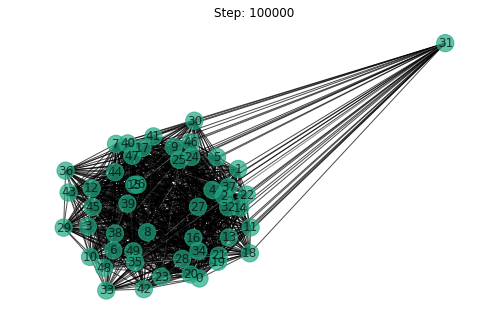

In [6]:
# Update_1_0: Update Original
sim.initialize()
sim.observe()
for i in range(10):
    for i in range(10000):
        sim.update_1_0()
    sim.observe()
    density_tracker_1_0.append(nx.density(sim.graph))

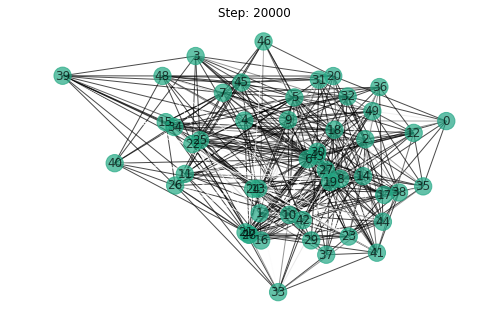

In [7]:
# Update_1_1: Update Opinions (Nodes)
sim.initialize()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update_1_1()
    sim.observe()
    density_tracker_1_1.append(nx.density(sim.graph))

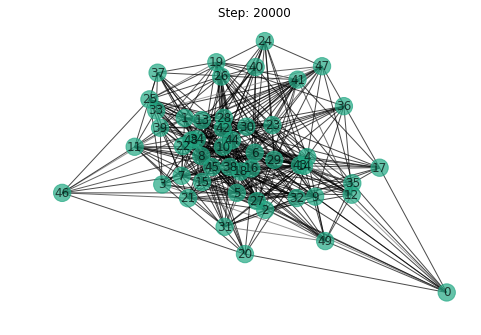

In [8]:
# Update_1_2: Update Weights (Edges)
sim.initialize()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update_1_2()
    sim.observe()
    density_tracker_1_2.append(nx.density(sim.graph))

In [9]:
d={"Update Original":density_tracker_1_0, 
   "Update Opinions":density_tracker_1_1,
   "Update Edges":density_tracker_1_2}

df = pd.DataFrame(d)
df

,Update Edges,Update Opinions,Update Original
0,0.200816,0.200816,0.127347
1,0.219592,0.219592,0.174694
2,0.235918,0.235918,0.235918
3,0.253061,0.253061,0.311020
4,0.264490,0.264490,0.387755
5,0.281633,0.281633,0.454694
6,0.293878,0.293878,0.549388
7,0.311837,0.311837,0.617143
8,0.326531,0.326531,0.703673
9,0.345306,0.345306,0.785306


In [10]:
df.describe()

,Update Edges,Update Opinions,Update Original
count,10.000000,10.000000,10.000000
mean,0.273306,0.273306,0.434694
std,0.047163,0.047163,0.226371
min,0.200816,0.200816,0.127347
25%,0.240204,0.240204,0.254694
50%,0.273061,0.273061,0.421224
75%,0.307347,0.307347,0.600204
max,0.345306,0.345306,0.785306


# Modification 2: Multiple topics
### SocialDynamicsSimulation3, SocialDynamicsSimulation3
### update_2_1, update_2_2

In [11]:
class SocialDynamicsSimulation3:
    '''
    Introduces 2 topics as a vector (array). Takes the average difference
    to continue computations. 
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        #self.graph = nx.watz_strogatz_graph(50, 5, 0.5)
        self.graph = nx.barabasi_albert_graph(50, 5, 0.5)
        
        topics = ['immigration', 'marriage']
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = [random.randint(0,1) for topic in topics]
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            #node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update_2_1(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            
            
            
            # loop through topics to create an average opinion difference
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                    for topic in self.graph.nodes[edge[i]]['opinion']: 
                        (opinions[i][topic] + self.alpha * weight * 
                         (opinions[1-i][topic] - opinions[i][topic]))
            
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * np.mean((abs(opinions[0][0]-opinions[1][0]) 
                                   + abs(opinions[0][1]-opinions[1][1])))))
            
            
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

/Users/annapauxberger/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


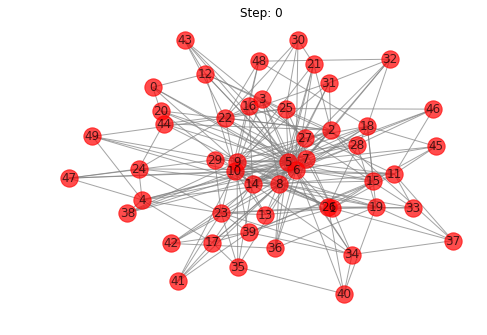

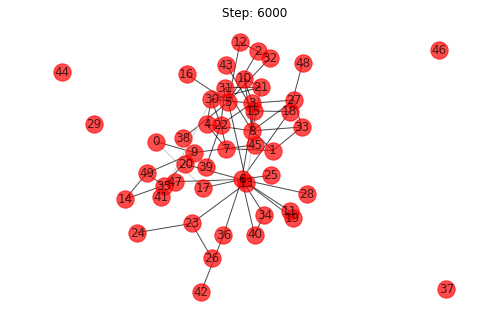

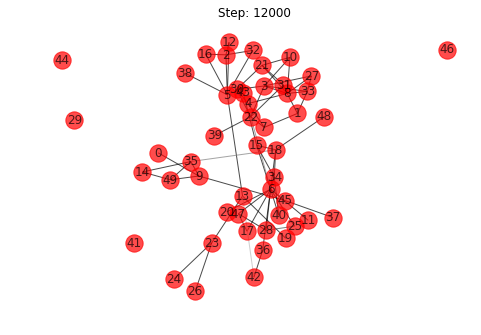

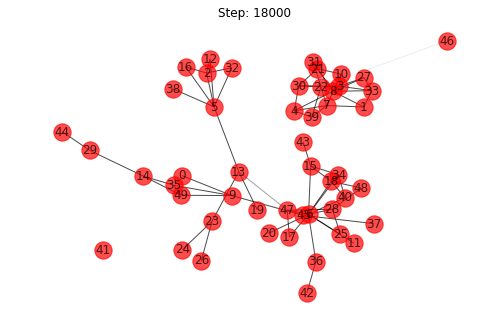

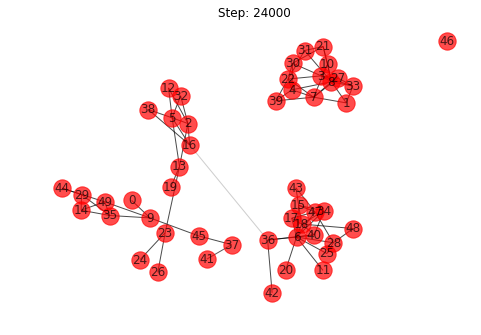

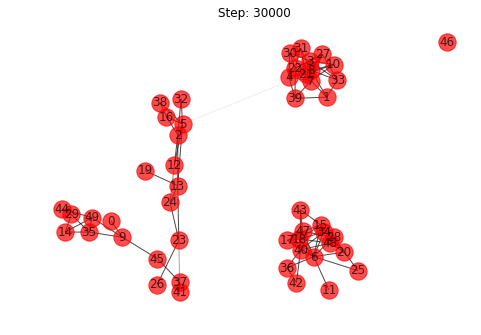

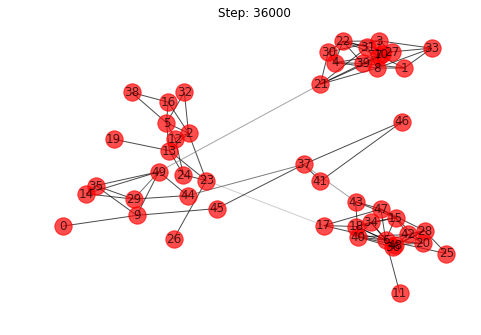

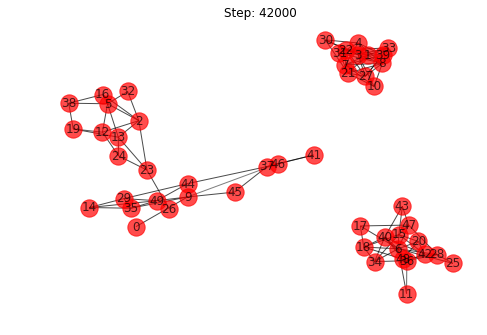

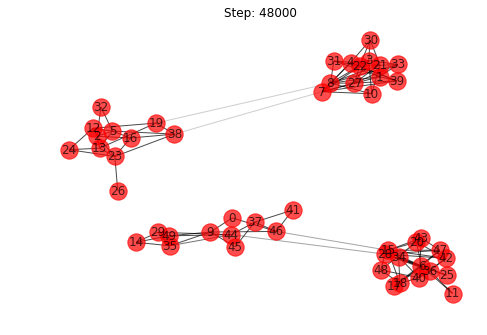

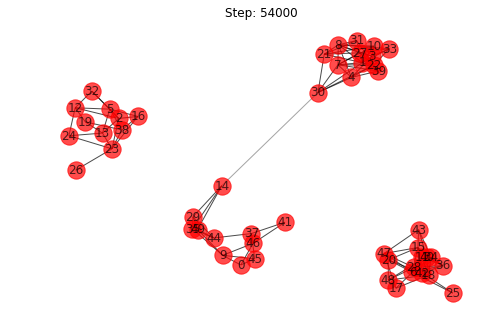

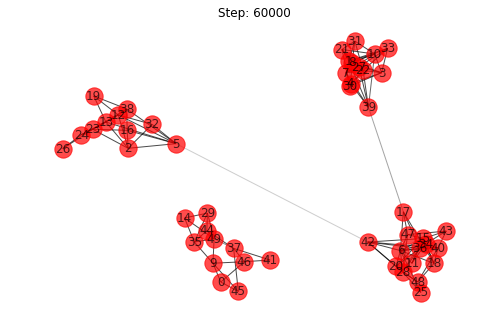

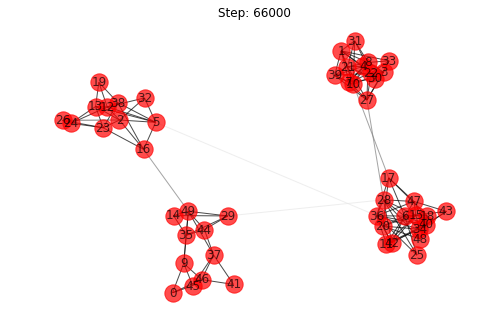

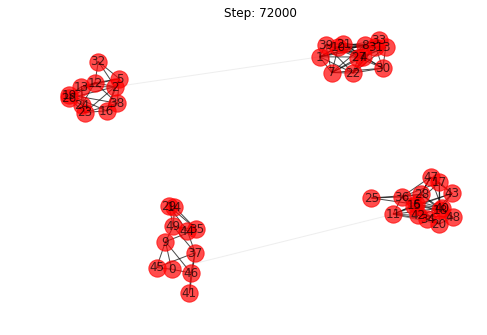

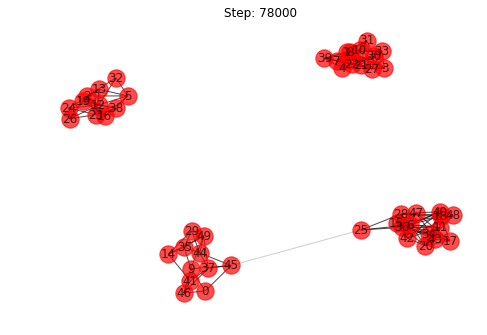

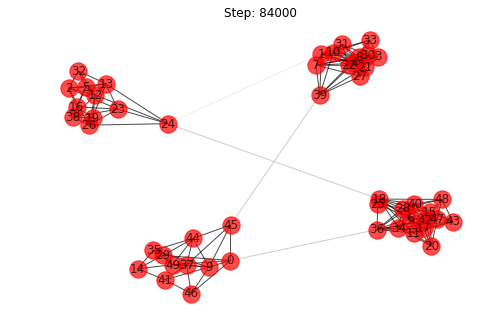

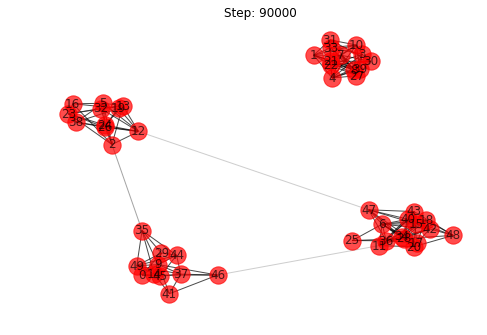

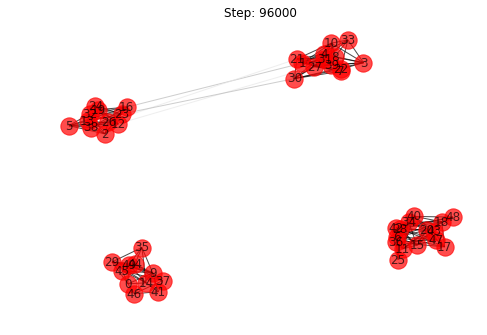

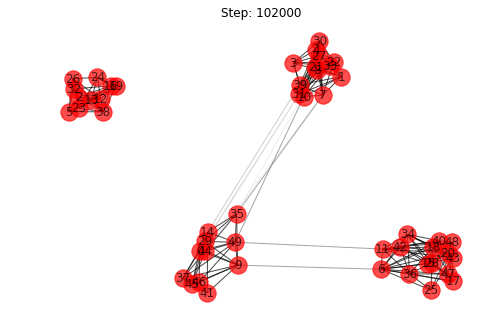

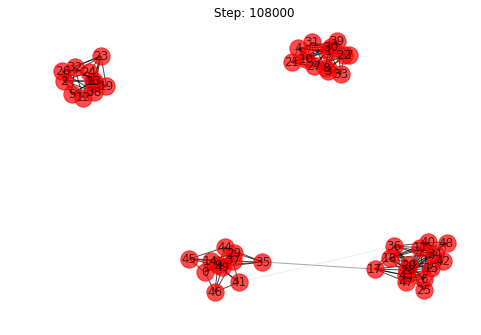

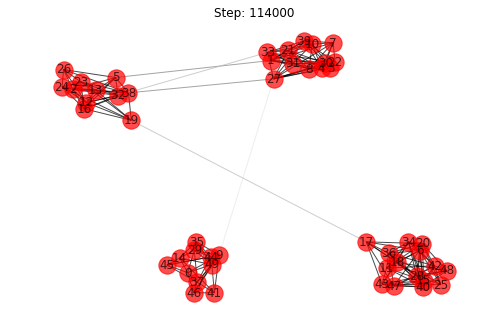

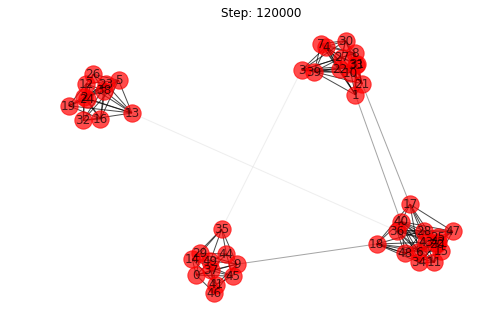

In [12]:
sim = SocialDynamicsSimulation3()
sim.initialize()
plt.figure()
sim.observe()
for i in range(20):
    for i in range(6000):
        sim.update_2_1()
    plt.figure()
    sim.observe()

In [13]:
class SocialDynamicsSimulation4:
    '''
    Introduces 3 topics as a vector (array). Takes the average difference
    to continue computations. 
    
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        #self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
        self.graph = nx.barabasi_albert_graph(self.network_size, 5, 0.5)
        topics = ['immigration', 'marriage', "economics"]
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = [random.randint(0,1) for topic in topics]
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            #node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update_2_2(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            
            
            
            # loop through topics of an opinion
            for i in [0, 1]:
                    for topic in self.graph.nodes[edge[i]]['opinion']: 
                        (opinions[i][topic] + self.alpha * weight * 
                         (opinions[1-i][topic] - opinions[i][topic]))
            
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * np.mean((abs(opinions[0][0]-opinions[1][0]) 
                                   + abs(opinions[0][1]-opinions[1][1]) 
                                   + abs(opinions[0][2]-opinions[1][2])))))
            
            
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

/Users/annapauxberger/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


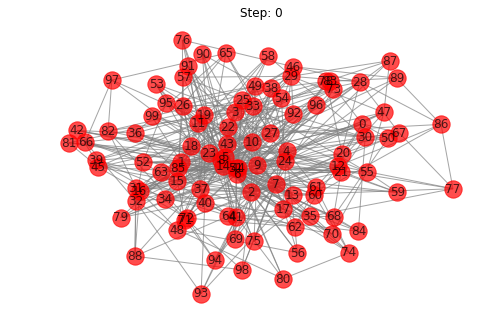

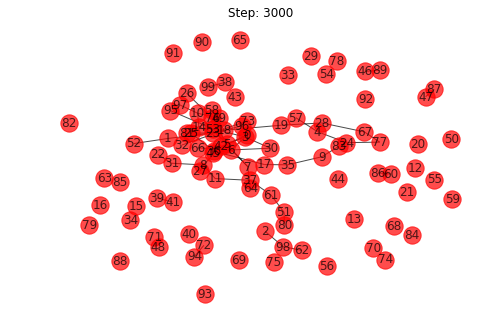

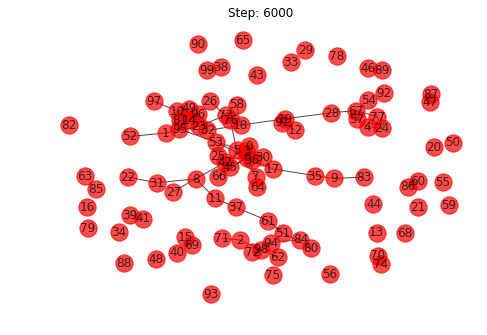

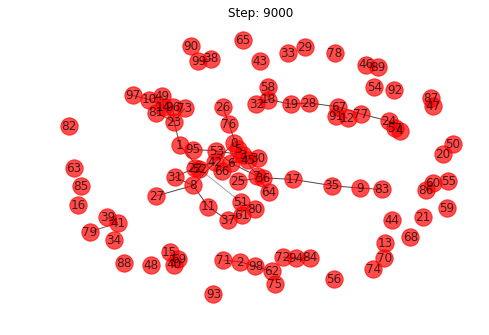

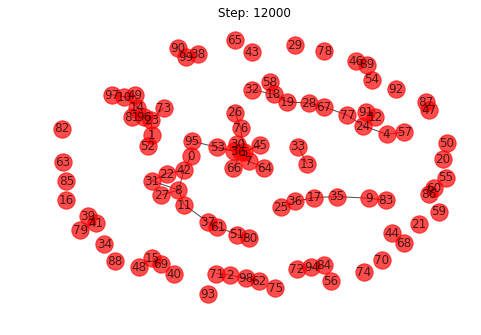

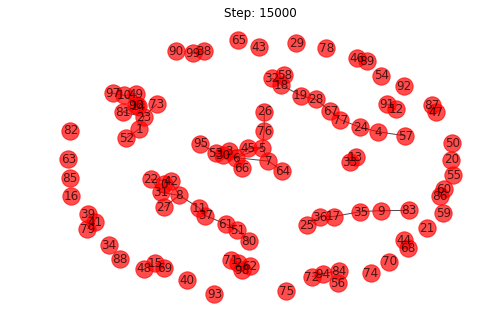

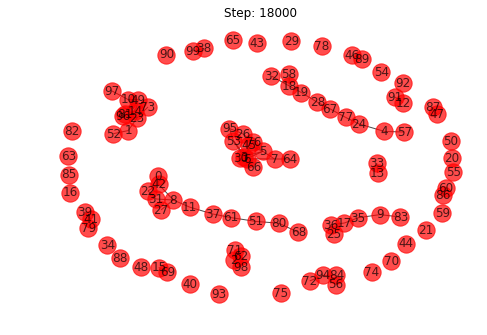

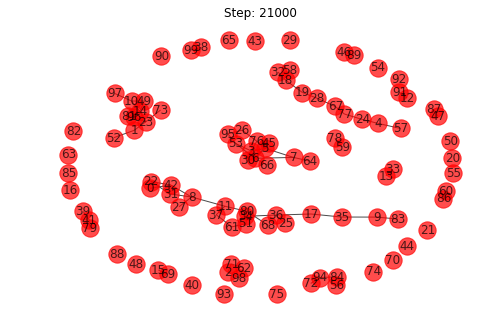

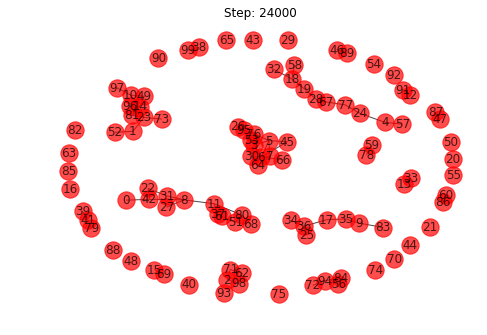

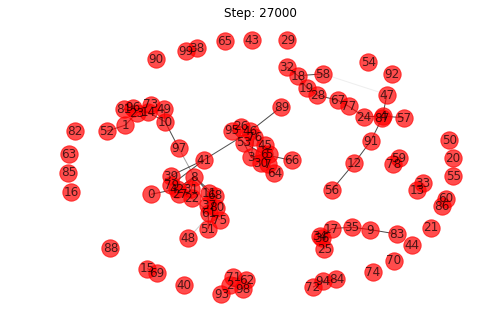

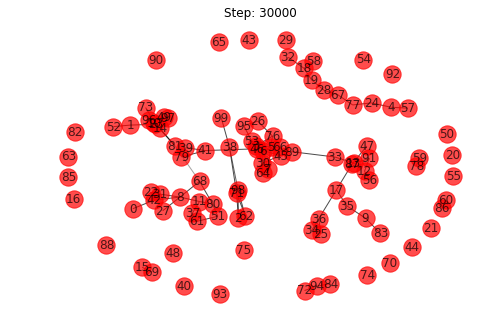

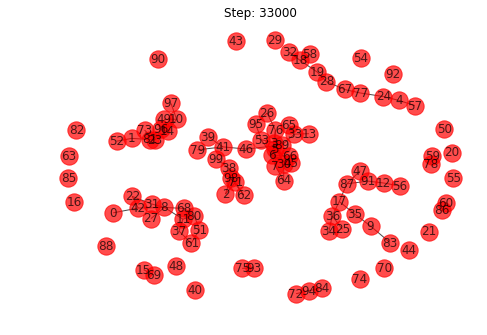

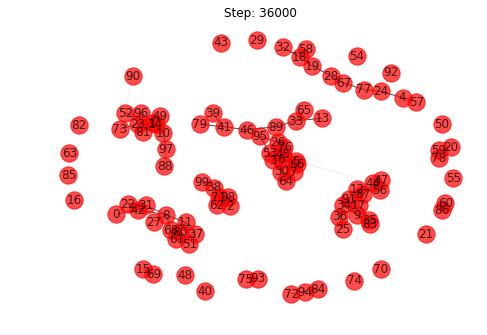

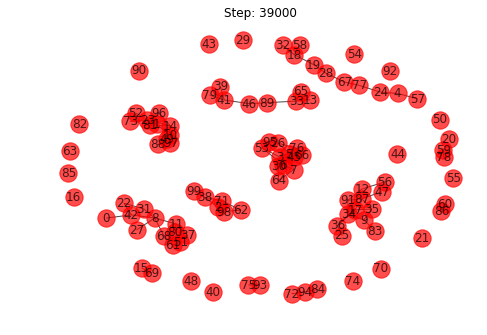

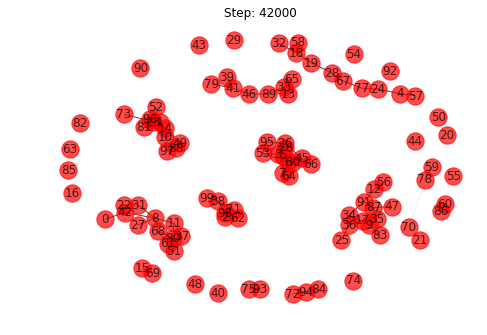

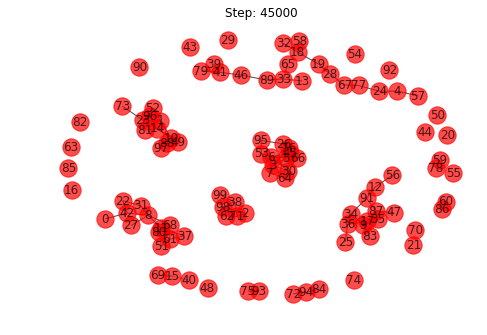

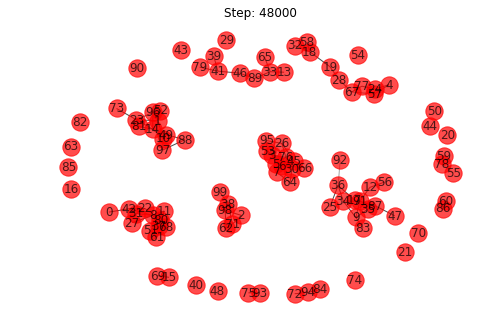

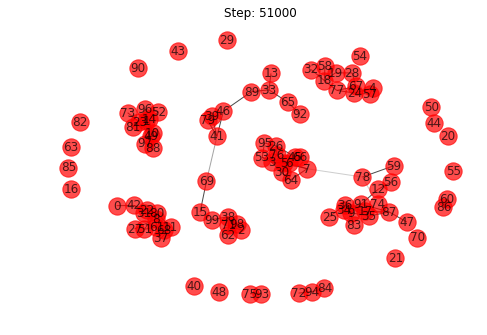

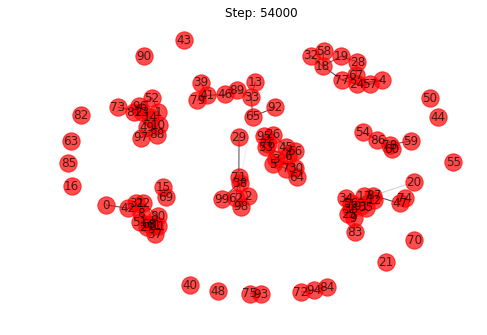

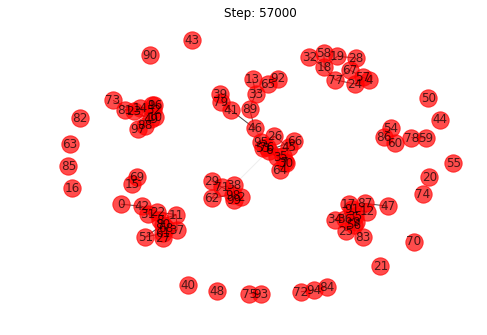

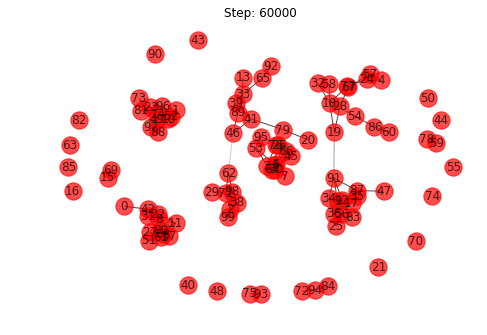

In [14]:
sim = SocialDynamicsSimulation4(network_size=100)
sim.initialize()
plt.figure()
sim.observe()
for i in range(20):
    for i in range(3000):
        sim.update_2_2()
    plt.figure()
    sim.observe()

# Local analysis

In [15]:
from matplotlib import pyplot
import itertools
import scipy

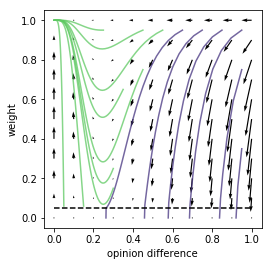

In [17]:
alpha = 0.03
beta = 0.3
gamma = 4

cmap = pyplot.cm.viridis  # color map to use

# Plot traces of how opinion and weight change over timehhhiv
for opinion, weight in [
    [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
    [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
    [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
]:
    ow = [[opinion, 0.0, weight]]
    for i in range(100):
        delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
        delta_w = (
            beta * ow[-1][2] * (1-ow[-1][2]) *
            (1-gamma*abs(ow[-1][1] - ow[-1][0])))
        new_weight = ow[-1][2] + delta_w
        new_opinion = ow[-1][0] + delta_o  
        if new_weight < 0.05:
            
            # update_1_0 original
            new_weight = 0
            
            # update_1_1 changes opinion
            # new_opinion = ow[-1][0] + 10 * delta_o
            
            # update_1_2 where it changes the weight only
            # new_weight = 0.2

        ow.append([new_opinion, ow[-1][1] - delta_o, new_weight])
    pyplot.plot(
        [row[0] - row[1] for row in ow],
        [row[2] for row in ow],
        color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
        alpha=0.75)

# Plot vector field
opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
ow_grid = scipy.meshgrid(opinion, weight)
delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0]
delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
pyplot.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

# Annotate plot
pyplot.xlabel('opinion difference')
pyplot.ylabel('weight')
pyplot.plot([0, 1], [0.05, 0.05], 'k--')
pyplot.axis('square')
pyplot.show()

# Simulation Analysis

In [19]:
# Experimenting with epsilon value for clusterings
sim = SocialDynamicsSimulation2()
runs = 5
epsilons = np.linspace(1,16,8)
clustering = [[] for x in range(runs)]

sim.initialize()
for run in range(runs):
    for e in epsilons:
        for i in range(2000):
            sim.update_1_1(epsilon=e)
        clustering[run].append(np.mean(nx.clustering(sim.graph)[1]))

In [20]:
d={"Clustering 2000 steps":clustering[0],
   "Clustering 4000 steps":clustering[1],
   "Clustering 6000 steps":clustering[2],
   "Clustering 8000 steps":clustering[3],
   "Clustering 10000 steps":clustering[4]
  }
df = pd.DataFrame(d, index = epsilons)
df

,Clustering 10000 steps,Clustering 2000 steps,Clustering 4000 steps,Clustering 6000 steps,Clustering 8000 steps
1.000000,0.711111,0.230769,0.320261,0.455840,0.576344
3.142857,0.729730,0.269231,0.333333,0.478836,0.593548
5.285714,0.738265,0.282051,0.345029,0.475369,0.617424
7.428571,0.755334,0.263736,0.371429,0.501149,0.634581
9.571429,0.769559,0.296703,0.380952,0.521839,0.648841
11.714286,0.782726,0.279412,0.409420,0.526882,0.657143
13.857143,0.793522,0.294118,0.433846,0.537634,0.675630
16.000000,0.810976,0.313725,0.433048,0.550538,0.692437


In [21]:
# Experimenting with epsilon value for densities
sim = SocialDynamicsSimulation2()
runs = 5
epsilons = np.linspace(1,16,8)
densities = [[] for x in range(runs)]

sim.initialize()

for run in range(runs):
    for e in epsilons:
        for i in range(2000):
            sim.update_1_1(epsilon=e)
        densities[run].append(np.mean(nx.density(sim.graph)))

In [22]:
d={"Density 2000 steps":densities[0],
   "Density 4000 steps":densities[1],
   "Density 6000 steps":densities[2],
   "Density 8000 steps":densities[3],
   "Density 10000 steps":densities[4]
  }
df = pd.DataFrame(d, index = epsilons)
df

,Density 10000 steps,Density 2000 steps,Density 4000 steps,Density 6000 steps,Density 8000 steps
1.000000,0.709388,0.200816,0.326531,0.467755,0.587755
3.142857,0.726531,0.219592,0.345306,0.480000,0.602449
5.285714,0.744490,0.235918,0.359184,0.491429,0.620408
7.428571,0.758367,0.253061,0.373878,0.511837,0.635102
9.571429,0.772245,0.264490,0.390204,0.528980,0.648980
11.714286,0.789388,0.281633,0.406531,0.537143,0.660408
13.857143,0.805714,0.293878,0.427755,0.550204,0.675102
16.000000,0.825306,0.311837,0.450612,0.567347,0.693061
